2) commnuty only: 전체 그래프 GRL없이 모든 커뮤니티에 대해 Local GRL 수행 (major / minor 구분 없이 모든 커뮤니티)

=> 정확도 최소, 병렬처리 가능 (처리속도 최상)
* 처리속도 = Parallel Local GRL 수행 시간 측정

In [1]:
import pandas as pd
from igraph import Graph
import igraph
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
import numpy as np
import stellargraph as sg
import pickle
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import GraphSAGELinkGenerator,GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from tensorflow import keras
import time
from collections import defaultdict
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

In [2]:
# Edge between two user node (607,333 friendships)
file = '/home/jhpark/dataset_WWW2019/dataset_WWW2019/dataset_WWW_friendship_new.txt'
g = nx.read_edgelist(file , nodetype = int, edgetype='Freindship')

In [3]:
ig = Graph.from_networkx(g) # NetworkX to igraph 
ig.vs["id"] = ig.vs["_nx_name"]
ig.es["weight"] = [1.0]*ig.ecount()

In [4]:
node_features_encoded = pd.read_csv("/home/jhpark/dataset_WWW2019/node_features_encoded.csv", index_col=0)
country_degree = pd.concat([node_features_encoded['countrycode_encoded'], node_features_encoded['degree']],axis=1)

In [5]:
userGraph_country_deg = StellarGraph.from_networkx(ig.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = country_degree)
print(userGraph_country_deg.info()) # 전체 그래프 load

StellarGraph: Undirected multigraph
 Nodes: 114324, Edges: 607333

 Node types:
  user: [114324]
    Features: float32 vector, length 2
    Edge types: user-friendship->user

 Edge types:
    user-friendship->user: [607333]
        Weights: all 1 (default)
        Features: none


In [6]:
LP = Graph.community_label_propagation(ig) # 커뮤니티 디텍션
LP.summary()

'Clustering with 114324 elements and 3902 clusters'

In [7]:
#mu = Graph.community_multilevel(ig)
#mu.summary()

In [8]:
eigen = Graph.community_leading_eigenvector(ig) # 4 Eigenvector-based => OK
eigen.summary()

'Clustering with 114324 elements and 1864 clusters'

In [7]:
# GraphSAGE Hyper-parameter Settings
batch_size = 20
epochs = 5
num_samples = [20, 10]
layer_sizes = [50, 50]

In [8]:
def subGraphSAGE(subgraphList):
    subgraph = ig.induced_subgraph(subgraphList,implementation="create_from_scratch")
    isin_filter = node_features_encoded['userID'].isin(subgraph.vs['id'])
    
    subgraph_features = node_features_encoded[isin_filter]
    subgraph_country_degree = pd.concat([subgraph_features['countrycode_encoded'], subgraph_features['degree']],axis=1)
    subgraph_country_degree.reset_index(drop=True,inplace=True)
    
    subgraph_ = StellarGraph.from_networkx(subgraph.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = subgraph_country_degree)
    
    if len(subgraph_.nodes()) > 100:
        print("Node개수: ",len(subgraph_.nodes()))
        
    subnodes = list(subgraph_.nodes())
    sub_unsupervised_samples = UnsupervisedSampler(
        subgraph_, nodes = subnodes, length=5, number_of_walks=1
    )
    
    sub_generator = GraphSAGELinkGenerator(subgraph_, batch_size, num_samples)
    sub_train_gen = sub_generator.flow(sub_unsupervised_samples)
    
    sub_graphsage = GraphSAGE(
        layer_sizes = layer_sizes, generator=sub_generator, bias=True, dropout=0.3, normalize="l2"
    )
    
    x_inp, x_out = sub_graphsage.in_out_tensors()
    x_inp_src = x_inp[0::2]
    x_out_src = x_out[0]
    sub_embedding_model = keras.Model(inputs = x_inp_src, outputs = x_out_src)
    
    sub_node_ids = subgraph_.nodes()
    sub_node_gen = GraphSAGENodeGenerator(subgraph_, batch_size, num_samples).flow(sub_node_ids)
    
    sub_node_embeddings = sub_embedding_model.predict(sub_node_gen, workers=4, verbose=0)
    
    return sub_node_embeddings

In [9]:
node_embeddings = defaultdict(lambda: np.zeros(dimensions)) # Initialization

In [10]:
start = time.time()
for community_no in range(len(LP)):
    # Intra Community Embedding 
    sub_node_embeddings = subGraphSAGE(LP[community_no])
    print(len(sub_node_embeddings))

    # 전체 그래프에 대한 GraphSAGE에 의해 도출된 feature를 아예 덮어쓰는 것. 
    j=0
    for i in LP[community_no]:
        node_embeddings[i] = sub_node_embeddings[j]
        j += 1
print("time :", time.time() - start) 

Node개수:  14770
14770
Node개수:  3329
3329
2
Node개수:  256
256
Node개수:  2167
2167
Node개수:  954
954
71
2
23
Node개수:  2850
2850
34
Node개수:  118
118
Node개수:  135
135
Node개수:  105
105
Node개수:  103
103
Node개수:  1527
1527
Node개수:  5641
5641
Node개수:  5692
5692
Node개수:  11499
11499
Node개수:  798
798
Node개수:  138
138
14
Node개수:  246
246
Node개수:  760
760
Node개수:  154
154
81
Node개수:  780
780
Node개수:  122
122
25
32
Node개수:  108
108
Node개수:  338
338
48
Node개수:  5531
5531
Node개수:  6758
6758
Node개수:  186
186
Node개수:  488
488
18
Node개수:  221
221
Node개수:  111
111
Node개수:  1287
1287
Node개수:  477
477
Node개수:  102
102
Node개수:  682
682
Node개수:  118
118
Node개수:  635
635
4
97
Node개수:  398
398
2
10
Node개수:  187
187
4
Node개수:  2276
2276
18
Node개수:  295
295
Node개수:  425
425
Node개수:  163
163
Node개수:  464
464
Node개수:  633
633
77
14
Node개수:  554
554
Node개수:  227
227
60
43
Node개수:  497
497
Node개수:  673
673
23
45
13
40
12
12
18
Node개수:  106
106
16
Node개수:  891
891
1
Node개수:  169
169
Node개수:  135
135
Node개수:  157
157
31
1

6
10
7
5
2
5
2
3
6
7
7
7
2
2
2
3
3
2
3
10
3
3
3
2
2
2
3
3
4
2
8
2
3
5
3
3
2
4
8
2
2
2
4
2
12
6
5
2
3
7
7
2
12
10
6
16
9
3
18
7
4
4
3
9
6
10
2
6
3
2
2
4
4
7
6
2
2
4
5
2
25
2
4
7
7
4
2
3
2
5
6
2
3
2
2
2
6
2
8
4
4
2
4
5
6
5
5
2
10
12
5
5
2
17
2
5
2
6
3
9
11
3
23
3
2
3
3
3
3
2
3
8
3
3
2
2
7
4
9
2
10
2
3
3
2
5
2
5
28
2
8
10
2
3
2
2
2
10
3
6
3
15
3
2
2
5
2
3
2
2
2
3
4
5
10
3
13
2
4
2
3
4
2
3
3
2
2
5
2
12
2
2
8
3
2
2
3
5
2
3
8
4
2
10
2
4
7
2
12
2
2
2
4
3
2
3
2
8
3
2
3
2
2
2
14
5
3
3
2
3
5
2
5
2
7
4
11
3
2


/home/jhpark/anaconda3/envs/graph/lib/python3.6/site-packages/stellargraph/data/unsupervised_sampler.py:151: RuntimeWarning: invalid value encountered in true_divide
  sampling_distribution


ValueError: probabilities contain NaN

In [13]:
len(node_embeddings)

110237

In [ ]:
"""start = time.time()

total_result = 0
pool = ProcessPoolExecutor()

procs = []
for community_no in range(len(LP)):
    procs.append(pool.submit(subGraphSAGE, LP[community_no]))

end = time.time()

print("수행시간: %f 초" % (end - start))
print("총결괏값: %s" % total_result)"""

In [ ]:
"""pool_obj = mp.Pool(5)
start = time.time()

community_idx = 0
for ret in pool_obj.imap(subGraphSAGE,list(LP)):
    sub_node_embeddings = ret
    j=0
    for i in LP[community_idx]:
        node_embeddings[i] = sub_node_embeddings[j]
        j += 1
    community_idx += 1
    
len(node_embeddings)

for community_idx in range(len(LP)):
    sub_node_embeddings = sub_node_embeddings_list[community_idx]
    j=0
    for i in LP[community_idx]:
        node_embeddings[i] = sub_node_embeddings[j]
        j += 1
len(node_embeddings)
# 왜 안될 까 !!!!!!!!!!!!!!!!!!!!
"""

### 전체 그래프에 대해서 Link Prediction 결과 확인

In [15]:
def graphsage_learning(edge_splitter_test,graph):
    # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
    # reduced graph G_test with the sampled links removed:
    G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
        p=0.1, method="global", keep_connected=True
    )

    # Define an edge splitter on the reduced graph G_test:
    edge_splitter_train = EdgeSplitter(G_test)

    # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
    # reduced graph G_train with the sampled links removed:
    G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
        p=0.1, method="global", keep_connected=True
    )

    train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples, weighted =True)
    train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
    test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples, weighted =True)
    test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

    graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
    )

    x_inp, x_out = graphsage.in_out_tensors()

    prediction = link_classification(
        output_dim=1, output_act="relu", edge_embedding_method="ip"
    )(x_out)

    model = keras.Model(inputs=x_inp, outputs=prediction)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["acc"],
    )

    init_train_metrics = model.evaluate(train_flow)
    init_test_metrics = model.evaluate(test_flow)

    print("\nTrain Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_train_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print("\nTest Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print()
    print("#################################################################################################################")

    history = model.fit(train_flow, epochs=50, validation_data=test_flow, verbose=2)
    
    import stellargraph as sg
    sg.utils.plot_history(history)

    print()
    print("################################################################################################################")

    train_metrics = model.evaluate(train_flow)
    test_metrics = model.evaluate(test_flow)

    print("\nTrain Set Metrics of the trained model:")
    for name, val in zip(model.metrics_names, train_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print("\nTest Set Metrics of the trained model:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    x_inp_src = x_inp[0::2]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
    
    node_ids = graph.nodes()
    node_gen = GraphSAGENodeGenerator(graph, batch_size, num_samples).flow(node_ids)
    node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)
    
    return node_embeddings


In [14]:
node_embeddings_df = pd.DataFrame(node_embeddings).transpose()

In [15]:
node_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.034623,-0.325036,-0.004413,-0.120760,-0.098282,-0.004931,-0.074464,0.142370,0.135149,-0.139962,...,-0.135989,0.094155,0.091712,-0.084346,-0.007546,0.022618,-0.397244,-0.110839,-0.078749,0.035433
1,0.046907,-0.304158,-0.014770,-0.086362,-0.135858,0.055492,-0.123662,0.114940,0.111082,-0.138744,...,-0.113426,0.092519,0.121983,-0.107136,-0.057188,0.001338,-0.404042,-0.103672,-0.087398,0.038875
2,0.050226,-0.328102,0.002013,-0.110832,-0.122171,0.015953,-0.090976,0.131865,0.131456,-0.134829,...,-0.138346,0.074698,0.099568,-0.096810,-0.034795,0.025888,-0.388115,-0.090228,-0.080493,0.030701
3,0.046293,-0.327057,-0.001295,-0.111800,-0.119955,0.017742,-0.093123,0.132805,0.132601,-0.136274,...,-0.139052,0.084456,0.097426,-0.099940,-0.035824,0.026331,-0.393829,-0.100290,-0.076526,0.035815
4,0.043555,-0.334650,-0.005805,-0.113448,-0.117778,0.017963,-0.094800,0.138042,0.134834,-0.144242,...,-0.104807,0.118592,0.092914,-0.082700,-0.017030,0.009040,-0.383219,-0.117145,-0.080943,0.054576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80829,0.246424,-0.027355,-0.019834,0.113986,0.118894,-0.260419,0.260062,0.033552,-0.067242,0.237671,...,0.133508,-0.115953,-0.038517,0.103065,-0.184388,0.074755,0.008504,0.322988,-0.012981,-0.203382
91045,0.246424,-0.027355,-0.019834,0.113986,0.118894,-0.260419,0.260062,0.033552,-0.067242,0.237671,...,0.133508,-0.115953,-0.038517,0.103065,-0.184388,0.074755,0.008504,0.322988,-0.012981,-0.203382
91047,0.246424,-0.027355,-0.019834,0.113986,0.118894,-0.260419,0.260062,0.033552,-0.067242,0.237671,...,0.133508,-0.115953,-0.038517,0.103065,-0.184388,0.074755,0.008504,0.322988,-0.012981,-0.203382
80841,-0.162183,0.099683,0.074245,-0.099501,-0.161809,-0.155586,-0.064273,-0.263764,-0.111640,0.175634,...,-0.038873,-0.166536,0.122625,-0.270438,-0.070393,-0.284035,0.055837,0.113650,-0.042089,-0.052036


In [22]:
merged_Graph = StellarGraph.from_networkx(ig.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = node_embeddings_df)

** Sampled 60733 positive and 60733 negative edges. **
** Sampled 54660 positive and 54660 negative edges. **
link_classification: using 'ip' method to combine node embeddings into edge embeddings
6074/6074 [==============================] - 293s 48ms/step - loss: 0.3556 - acc: 0.8779

Train Set Metrics of the initial (untrained) model:
	loss: 0.3554
	acc: 0.8772

Test Set Metrics of the initial (untrained) model:
	loss: 0.3556
	acc: 0.8779

#################################################################################################################
Epoch 1/5
5466/5466 - 507s - loss: 0.2388 - acc: 0.9352 - val_loss: 0.2183 - val_acc: 0.9450
Epoch 2/5
5466/5466 - 507s - loss: 0.1988 - acc: 0.9413 - val_loss: 0.2096 - val_acc: 0.9458
Epoch 3/5
5466/5466 - 510s - loss: 0.1862 - acc: 0.9452 - val_loss: 0.2149 - val_acc: 0.9406
Epoch 4/5
5466/5466 - 508s - loss: 0.1752 - acc: 0.9485 - val_loss: 0.1918 - val_acc: 0.9497
Epoch 5/5
5466/5466 - 509s - loss: 0.1746 - acc: 0.9482 - val_loss: 

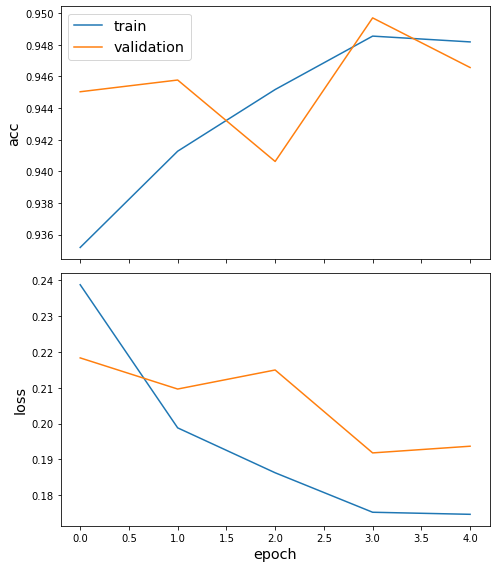

In [23]:
start = time.time()
edge_splitter_test = EdgeSplitter(merged_Graph)
graphsage_learning(edge_splitter_test, merged_Graph)
print("time for link prediction :", time.time() - start) 

In [ ]:
"""
@@@ NO PARALLEL PROCESSING VERSION @@@
start = time.time()
for community_no in range(len(cd_algo)):
    # Intra Community Embedding 
    if len(cd_algo[community_no]) >= 100:
        sub_node_embeddings = subGraphSAGE(cd_algo[community_no])
        print(len(sub_node_embeddings))
        
        # 전체 그래프에 대한 GraphSAGE에 의해 도출된 feature를 아예 덮어쓰는 것. 
        j=0
        for i in cd_algo[community_no]:
            node_embeddings[i] = sub_node_embeddings[j]
            j += 1
print("time :", time.time() - start) """